In [1]:
import pathlib
import json
from IPython.display import clear_output
import cv2
import numpy as np

In [2]:
# js_files = list(pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\official').iterdir())
js_files = list(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\official').iterdir())
for i,js in enumerate(js_files):
    print(i)
    official_label = json.loads(js.read_text(encoding='utf8'))
    H = int(official_label['imageHeight'])
    W = int(official_label['imageWidth'])
    
    bboxes = []
    for shape in official_label['shapes']:
        polygon = np.array(shape['points'])
        #因為標記座標可能超出圖片範圍，所以要修正
        polygon[:,0] = np.clip(polygon[:,0],0,W)
        polygon[:,1] = np.clip(polygon[:,1],0,H)
        #(left,top)為bbox左上角座標  w,h是寬高長度
        left,top,w,h = cv2.boundingRect(polygon)
        #避免左上角超出圖片範圍
        left =  np.clip(left,0,W)
        top = np.clip(top,0,H)
        #長寬不明原因會大於圖片長寬，用np.clip處理
        #另外還要注意左上座標加上長寬不能超過圖片大小
        w = np.clip(w,0,W-left)
        h = np.clip(h,0,H-top)
        
        #四邊形座標依照圖片尺寸正規化
        polygon = polygon/np.array([W,H])
        #矩形bbox的xywh依照圖片尺寸正規化
        left,w = left/W, w/W
        top,h = top/H, h/H
        
        right = left + w
        bottom = top + h
        
        bbox = {}
        bbox['text'] = shape['label']
        bbox['type'] = shape['group_id']
        
        bbox['rectangle'] = {}
        bbox['rectangle']['center'] = [(left + right)/2, (top + bottom)/2]
        bbox['rectangle']['ltwh'] = [left,top,w,h]
        bbox['rectangle']['points'] = [[left,top],[right,top],[right,bottom],[left,bottom]]
        
        bbox['polygon'] = {}
        bbox['polygon']['center'] = polygon.mean(axis=0).tolist()
        bbox['polygon']['points'] = polygon.tolist()
        
        bboxes.append(bbox)
    
    my_label = {}
    my_label['ImageName'] = official_label['imagePath']
    my_label['ImageHeight'] = H
    my_label['ImageWidth'] = W
    my_label['bboxes'] = bboxes
    my_label['bboxes_count'] = len(bboxes)
    
    s = json.dumps(my_label)
    pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom').joinpath(js.name).write_text(s)
#     pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom').joinpath(js.name).write_text(s)
    clear_output(wait=True)
print('Finish')

Finish


In [5]:
import matplotlib.pyplot as plt

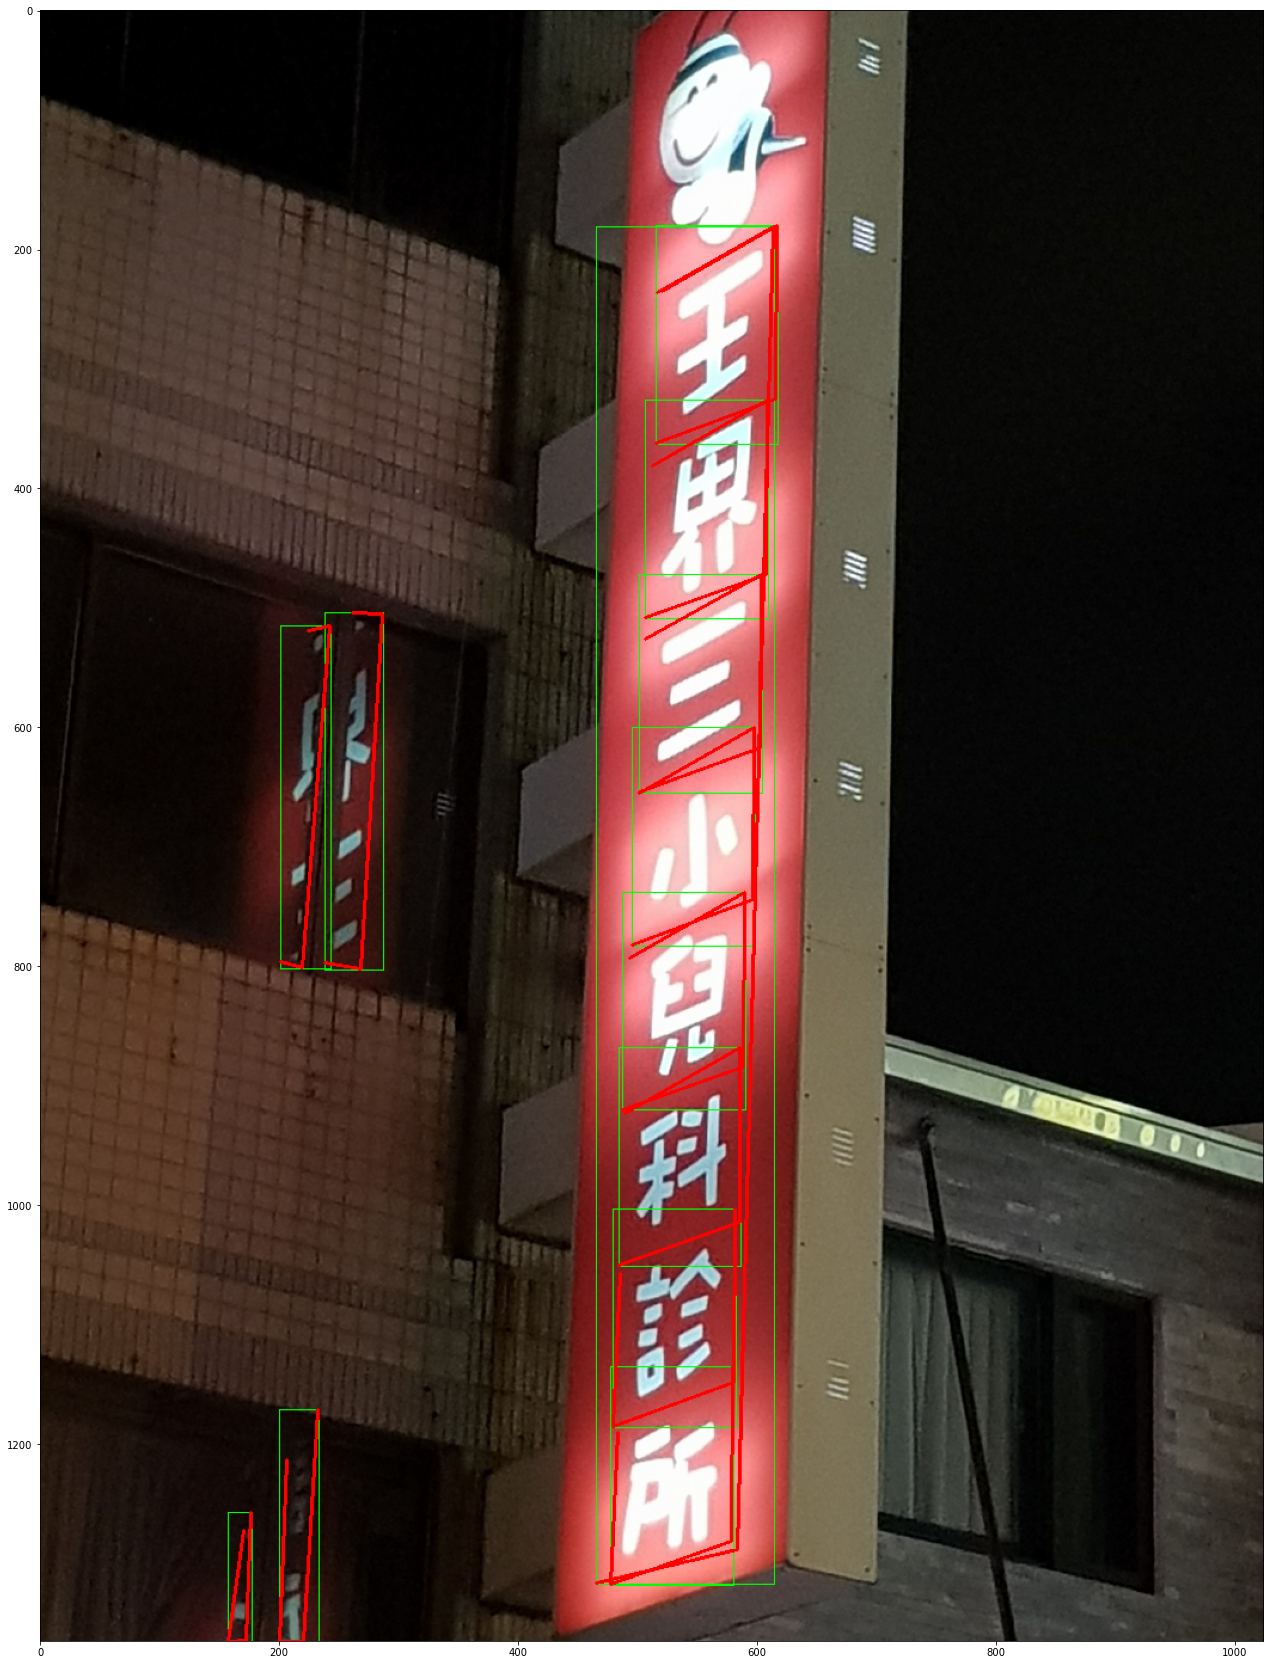

In [54]:
number = 419
name = f'img_{number}.json'
x = json.loads(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom').joinpath(name).read_text(encoding='utf8'))
img = plt.imread(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official').joinpath(x['ImageName']))

rects = np.array([b['rectangle']['points'] for b in x['bboxes']])
rects = (rects * np.array([x['ImageWidth'],x['ImageHeight']])).astype(int)

polygon = np.array([b['polygon']['points'] for b in x['bboxes']])
polygon = (polygon * np.array([x['ImageWidth'],x['ImageHeight']])).astype(int)

img = cv2.polylines(img,rects,True,(0,255,0))
img = cv2.polylines(img,polygon,False,(255,0,0),2)

plt.figure(figsize=(30,30))
plt.imshow(img)